In [1]:
import csv
import pandas as pd
import xgboost as xgb
import numpy as np
import math
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from graphviz import Digraph
from sklearn.metrics import accuracy_score

import pickle

#matplotlibの日本語文字化けを避ける設定
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']

In [3]:
with open("train_processed_20200830_2.csv",'r',newline='',encoding="utf_8_sig") as inputfile: #改行コードがあることを明示,BOM付きファイル削除
    #DataFrameを作成。pandasuはread_csv()がカンマ区切り、read_table()がタブ区切りを読み込む
    train_data = pd.read_csv(inputfile)
    #header : ヘッダーがないのでNoneを指定。あれば0を指定（指定しないと１行目は勝手にヘッダー扱いになる）、
    #name : 適当に名前を付与
    #index_col : 行番号をindexに指定
    #usecols ：CSVの読み込み対象とする列を指定するprint("dfタイプ：", type(df))
print("\nサンプル表示\n")
train_data[0:1]


サンプル表示



,y,city,property_type,room_type,accommodates,bathrooms,bed_type,bedrooms,beds,review_scores_rating,host_response_rate,host_has_profile_pic
0,138.0,3,0,1,6,2.0,4,1.0,4.0,-4.96437,-1.650707,1


In [4]:
# 2列目以降を特徴量として使う
x = train_data.iloc[:, 1:]
# 確認 :
print('Feature data :', x[0:1])

Feature data :    city  property_type  room_type  accommodates  bathrooms  bed_type  \
0     3              0          1             6        2.0         4   

   bedrooms  beds  review_scores_rating  host_response_rate  \
0       1.0   4.0              -4.96437           -1.650707   

   host_has_profile_pic  
0                     1  


In [5]:
# 0列目が正解ラベル
y = train_data.iloc[:, 0]
# 確認 :
print('answer :', y)

answer : 0        138.0
1         42.0
2         65.0
3        166.0
4        165.0
         ...  
55578    340.0
55579     30.0
55580    100.0
55581     38.0
55582     50.0
Name: y, Length: 55583, dtype: float64


In [6]:
# データセットを学習用と検証用に分割する
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=42)

print("x_train.shape : ", x_train.shape)
print("x_test.shape : ", x_test.shape)
print("y_train.shape : ", y_train.shape)
print("y_test.shape : ", y_test.shape)

# XGBoost が扱うデータセットの形式に直す
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

x_train.shape :  (44466, 11)
x_test.shape :  (11117, 11)
y_train.shape :  (44466,)
y_test.shape :  (11117,)


In [7]:
# モデル設定
clf = xgb.XGBRegressor()

# ハイパーパラメータ探索
clf_cv = GridSearchCV(clf, 
                      {'max_depth': [x for x in range(4,10,2)],
                       'n_estimators': [x for x in range(40,80,10)],
                       'learning_rate': [0.1,0.2,0.3,0.4,0.5],
                       'min_child_weight':[x for x in range(1,8,2)]}
                      ,scoring= 'neg_mean_squared_error', n_jobs=1,verbose=3)
clf_cv.fit(x_train, y_train)

print(clf_cv.best_params_, clf_cv.best_score_)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
[CV] learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=40 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=40, score=-13339.976, total=   0.8s
[CV] learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=40 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=40, score=-16130.156, total=   0.8s
[CV] learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=40 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=40, score=-15315.008, total=   0.8s
[CV] learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=40 
[CV]  learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=40, score=-13321.826, total=   0.8s
[CV] learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=40 
[CV]  learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=40, score=-13893.406, total=   0.8s
[CV] learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=50 
[CV]  learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=50, score=-13130.935, total=   0.9s
[CV] learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=50 
[CV]  learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=50, score=-15791.233, total=   0.9s
[CV] learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=50 
[CV]  learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=50, score=-15114.486, to

[CV]  learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=50, score=-12997.602, total=   1.0s
[CV] learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=50 
[CV]  learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=50, score=-13592.915, total=   1.0s
[CV] learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=60 
[CV]  learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=60, score=-13028.856, total=   1.2s
[CV] learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=60 
[CV]  learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=60, score=-15584.008, total=   1.3s
[CV] learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=60 
[CV]  learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=60, score=-14892.101, total=   1.2s
[CV] learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=60 
[CV]  learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=60, score=-12875.865, to

[CV]  learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=60, score=-13395.567, total=   1.7s
[CV] learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=70 
[CV]  learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=70, score=-13015.858, total=   1.9s
[CV] learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=70 
[CV]  learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=70, score=-15084.424, total=   2.0s
[CV] learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=70 
[CV]  learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=70, score=-14462.745, total=   2.0s
[CV] learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=70 
[CV]  learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=70, score=-12715.014, total=   2.2s
[CV] learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=70 
[CV]  learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=70, score=-13437.866, to

[CV]  learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=40, score=-13006.094, total=   1.2s
[CV] learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=40 
[CV]  learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=40, score=-15434.697, total=   1.2s
[CV] learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=40 
[CV]  learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=40, score=-14633.310, total=   1.2s
[CV] learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=40 
[CV]  learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=40, score=-12841.044, total=   1.3s
[CV] learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=40 
[CV]  learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=40, score=-13317.299, total=   1.2s
[CV] learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=50 
[CV]  learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=50, score=-12946.032, to

[CV]  learning_rate=0.1, max_depth=8, min_child_weight=3, n_estimators=50, score=-15390.594, total=   2.6s
[CV] learning_rate=0.1, max_depth=8, min_child_weight=3, n_estimators=50 
[CV]  learning_rate=0.1, max_depth=8, min_child_weight=3, n_estimators=50, score=-14458.496, total=   2.7s
[CV] learning_rate=0.1, max_depth=8, min_child_weight=3, n_estimators=50 
[CV]  learning_rate=0.1, max_depth=8, min_child_weight=3, n_estimators=50, score=-12818.636, total=   2.6s
[CV] learning_rate=0.1, max_depth=8, min_child_weight=3, n_estimators=50 
[CV]  learning_rate=0.1, max_depth=8, min_child_weight=3, n_estimators=50, score=-13452.194, total=   2.5s
[CV] learning_rate=0.1, max_depth=8, min_child_weight=3, n_estimators=60 
[CV]  learning_rate=0.1, max_depth=8, min_child_weight=3, n_estimators=60, score=-13134.534, total=   2.5s
[CV] learning_rate=0.1, max_depth=8, min_child_weight=3, n_estimators=60 
[CV]  learning_rate=0.1, max_depth=8, min_child_weight=3, n_estimators=60, score=-15386.817, to

[CV]  learning_rate=0.1, max_depth=8, min_child_weight=7, n_estimators=60, score=-14348.012, total=   4.7s
[CV] learning_rate=0.1, max_depth=8, min_child_weight=7, n_estimators=60 
[CV]  learning_rate=0.1, max_depth=8, min_child_weight=7, n_estimators=60, score=-12881.814, total=   4.8s
[CV] learning_rate=0.1, max_depth=8, min_child_weight=7, n_estimators=60 
[CV]  learning_rate=0.1, max_depth=8, min_child_weight=7, n_estimators=60, score=-13497.490, total=   4.5s
[CV] learning_rate=0.1, max_depth=8, min_child_weight=7, n_estimators=70 
[CV]  learning_rate=0.1, max_depth=8, min_child_weight=7, n_estimators=70, score=-12997.989, total=   5.1s
[CV] learning_rate=0.1, max_depth=8, min_child_weight=7, n_estimators=70 
[CV]  learning_rate=0.1, max_depth=8, min_child_weight=7, n_estimators=70, score=-15304.517, total=   5.4s
[CV] learning_rate=0.1, max_depth=8, min_child_weight=7, n_estimators=70 
[CV]  learning_rate=0.1, max_depth=8, min_child_weight=7, n_estimators=70, score=-14332.494, to

[CV]  learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=70, score=-12835.046, total=   2.6s
[CV] learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=70 
[CV]  learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=70, score=-13453.473, total=   2.9s
[CV] learning_rate=0.2, max_depth=4, min_child_weight=5, n_estimators=40 
[CV]  learning_rate=0.2, max_depth=4, min_child_weight=5, n_estimators=40, score=-12960.328, total=   1.5s
[CV] learning_rate=0.2, max_depth=4, min_child_weight=5, n_estimators=40 
[CV]  learning_rate=0.2, max_depth=4, min_child_weight=5, n_estimators=40, score=-15443.868, total=   1.8s
[CV] learning_rate=0.2, max_depth=4, min_child_weight=5, n_estimators=40 
[CV]  learning_rate=0.2, max_depth=4, min_child_weight=5, n_estimators=40, score=-14849.373, total=   1.6s
[CV] learning_rate=0.2, max_depth=4, min_child_weight=5, n_estimators=40 
[CV]  learning_rate=0.2, max_depth=4, min_child_weight=5, n_estimators=40, score=-12847.701, to

[CV]  learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=40, score=-13480.092, total=   1.2s
[CV] learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=50 
[CV]  learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=50, score=-13303.244, total=   1.4s
[CV] learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=50 
[CV]  learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=50, score=-15179.479, total=   1.5s
[CV] learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=50 
[CV]  learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=50, score=-14513.096, total=   1.4s
[CV] learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=50 
[CV]  learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=50, score=-12863.872, total=   1.5s
[CV] learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=50 
[CV]  learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=50, score=-13561.759, to

[CV]  learning_rate=0.2, max_depth=6, min_child_weight=5, n_estimators=60, score=-13142.686, total=   1.7s
[CV] learning_rate=0.2, max_depth=6, min_child_weight=5, n_estimators=60 
[CV]  learning_rate=0.2, max_depth=6, min_child_weight=5, n_estimators=60, score=-15315.019, total=   1.7s
[CV] learning_rate=0.2, max_depth=6, min_child_weight=5, n_estimators=60 
[CV]  learning_rate=0.2, max_depth=6, min_child_weight=5, n_estimators=60, score=-14551.398, total=   1.7s
[CV] learning_rate=0.2, max_depth=6, min_child_weight=5, n_estimators=60 
[CV]  learning_rate=0.2, max_depth=6, min_child_weight=5, n_estimators=60, score=-12807.672, total=   1.7s
[CV] learning_rate=0.2, max_depth=6, min_child_weight=5, n_estimators=60 
[CV]  learning_rate=0.2, max_depth=6, min_child_weight=5, n_estimators=60, score=-13468.858, total=   1.7s
[CV] learning_rate=0.2, max_depth=6, min_child_weight=5, n_estimators=70 
[CV]  learning_rate=0.2, max_depth=6, min_child_weight=5, n_estimators=70, score=-13187.328, to

[CV]  learning_rate=0.2, max_depth=8, min_child_weight=1, n_estimators=70, score=-15625.338, total=   2.8s
[CV] learning_rate=0.2, max_depth=8, min_child_weight=1, n_estimators=70 
[CV]  learning_rate=0.2, max_depth=8, min_child_weight=1, n_estimators=70, score=-15171.383, total=   2.7s
[CV] learning_rate=0.2, max_depth=8, min_child_weight=1, n_estimators=70 
[CV]  learning_rate=0.2, max_depth=8, min_child_weight=1, n_estimators=70, score=-13176.191, total=   2.7s
[CV] learning_rate=0.2, max_depth=8, min_child_weight=1, n_estimators=70 
[CV]  learning_rate=0.2, max_depth=8, min_child_weight=1, n_estimators=70, score=-14320.083, total=   2.6s
[CV] learning_rate=0.2, max_depth=8, min_child_weight=3, n_estimators=40 
[CV]  learning_rate=0.2, max_depth=8, min_child_weight=3, n_estimators=40, score=-13427.878, total=   1.6s
[CV] learning_rate=0.2, max_depth=8, min_child_weight=3, n_estimators=40 
[CV]  learning_rate=0.2, max_depth=8, min_child_weight=3, n_estimators=40, score=-15426.647, to

[CV]  learning_rate=0.2, max_depth=8, min_child_weight=7, n_estimators=40, score=-14587.034, total=   1.5s
[CV] learning_rate=0.2, max_depth=8, min_child_weight=7, n_estimators=40 
[CV]  learning_rate=0.2, max_depth=8, min_child_weight=7, n_estimators=40, score=-12996.125, total=   1.6s
[CV] learning_rate=0.2, max_depth=8, min_child_weight=7, n_estimators=40 
[CV]  learning_rate=0.2, max_depth=8, min_child_weight=7, n_estimators=40, score=-13844.208, total=   1.6s
[CV] learning_rate=0.2, max_depth=8, min_child_weight=7, n_estimators=50 
[CV]  learning_rate=0.2, max_depth=8, min_child_weight=7, n_estimators=50, score=-13319.833, total=   1.9s
[CV] learning_rate=0.2, max_depth=8, min_child_weight=7, n_estimators=50 
[CV]  learning_rate=0.2, max_depth=8, min_child_weight=7, n_estimators=50, score=-15535.807, total=   1.9s
[CV] learning_rate=0.2, max_depth=8, min_child_weight=7, n_estimators=50 
[CV]  learning_rate=0.2, max_depth=8, min_child_weight=7, n_estimators=50, score=-14625.713, to

[CV]  learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=50, score=-12856.951, total=   2.0s
[CV] learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=50 
[CV]  learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=50, score=-13589.301, total=   1.8s
[CV] learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=60 
[CV]  learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=60, score=-13219.809, total=   2.0s
[CV] learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=60 
[CV]  learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=60, score=-15270.402, total=   1.9s
[CV] learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=60 
[CV]  learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=60, score=-14533.363, total=   1.9s
[CV] learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=60 
[CV]  learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=60, score=-12883.597, to

[CV]  learning_rate=0.3, max_depth=4, min_child_weight=7, n_estimators=60, score=-13652.173, total=   2.3s
[CV] learning_rate=0.3, max_depth=4, min_child_weight=7, n_estimators=70 
[CV]  learning_rate=0.3, max_depth=4, min_child_weight=7, n_estimators=70, score=-13058.166, total=   2.6s
[CV] learning_rate=0.3, max_depth=4, min_child_weight=7, n_estimators=70 
[CV]  learning_rate=0.3, max_depth=4, min_child_weight=7, n_estimators=70, score=-15225.911, total=   2.5s
[CV] learning_rate=0.3, max_depth=4, min_child_weight=7, n_estimators=70 
[CV]  learning_rate=0.3, max_depth=4, min_child_weight=7, n_estimators=70, score=-14543.531, total=   2.6s
[CV] learning_rate=0.3, max_depth=4, min_child_weight=7, n_estimators=70 
[CV]  learning_rate=0.3, max_depth=4, min_child_weight=7, n_estimators=70, score=-12782.769, total=   2.6s
[CV] learning_rate=0.3, max_depth=4, min_child_weight=7, n_estimators=70 
[CV]  learning_rate=0.3, max_depth=4, min_child_weight=7, n_estimators=70, score=-13590.512, to

[CV]  learning_rate=0.3, max_depth=6, min_child_weight=5, n_estimators=40, score=-13212.578, total=   1.1s
[CV] learning_rate=0.3, max_depth=6, min_child_weight=5, n_estimators=40 
[CV]  learning_rate=0.3, max_depth=6, min_child_weight=5, n_estimators=40, score=-15303.130, total=   1.1s
[CV] learning_rate=0.3, max_depth=6, min_child_weight=5, n_estimators=40 
[CV]  learning_rate=0.3, max_depth=6, min_child_weight=5, n_estimators=40, score=-14586.928, total=   1.1s
[CV] learning_rate=0.3, max_depth=6, min_child_weight=5, n_estimators=40 
[CV]  learning_rate=0.3, max_depth=6, min_child_weight=5, n_estimators=40, score=-12956.392, total=   1.1s
[CV] learning_rate=0.3, max_depth=6, min_child_weight=5, n_estimators=40 
[CV]  learning_rate=0.3, max_depth=6, min_child_weight=5, n_estimators=40, score=-13608.115, total=   1.1s
[CV] learning_rate=0.3, max_depth=6, min_child_weight=5, n_estimators=50 
[CV]  learning_rate=0.3, max_depth=6, min_child_weight=5, n_estimators=50, score=-13400.771, to

[CV]  learning_rate=0.3, max_depth=8, min_child_weight=1, n_estimators=50, score=-16073.828, total=   1.8s
[CV] learning_rate=0.3, max_depth=8, min_child_weight=1, n_estimators=50 
[CV]  learning_rate=0.3, max_depth=8, min_child_weight=1, n_estimators=50, score=-15319.914, total=   1.8s
[CV] learning_rate=0.3, max_depth=8, min_child_weight=1, n_estimators=50 
[CV]  learning_rate=0.3, max_depth=8, min_child_weight=1, n_estimators=50, score=-13503.634, total=   1.7s
[CV] learning_rate=0.3, max_depth=8, min_child_weight=1, n_estimators=50 
[CV]  learning_rate=0.3, max_depth=8, min_child_weight=1, n_estimators=50, score=-13903.756, total=   1.8s
[CV] learning_rate=0.3, max_depth=8, min_child_weight=1, n_estimators=60 
[CV]  learning_rate=0.3, max_depth=8, min_child_weight=1, n_estimators=60, score=-14304.570, total=   2.1s
[CV] learning_rate=0.3, max_depth=8, min_child_weight=1, n_estimators=60 
[CV]  learning_rate=0.3, max_depth=8, min_child_weight=1, n_estimators=60, score=-16165.568, to

[CV]  learning_rate=0.3, max_depth=8, min_child_weight=5, n_estimators=60, score=-14991.748, total=   2.0s
[CV] learning_rate=0.3, max_depth=8, min_child_weight=5, n_estimators=60 
[CV]  learning_rate=0.3, max_depth=8, min_child_weight=5, n_estimators=60, score=-13339.067, total=   2.0s
[CV] learning_rate=0.3, max_depth=8, min_child_weight=5, n_estimators=60 
[CV]  learning_rate=0.3, max_depth=8, min_child_weight=5, n_estimators=60, score=-14173.712, total=   2.0s
[CV] learning_rate=0.3, max_depth=8, min_child_weight=5, n_estimators=70 
[CV]  learning_rate=0.3, max_depth=8, min_child_weight=5, n_estimators=70, score=-13618.743, total=   2.4s
[CV] learning_rate=0.3, max_depth=8, min_child_weight=5, n_estimators=70 
[CV]  learning_rate=0.3, max_depth=8, min_child_weight=5, n_estimators=70, score=-16092.974, total=   2.4s
[CV] learning_rate=0.3, max_depth=8, min_child_weight=5, n_estimators=70 
[CV]  learning_rate=0.3, max_depth=8, min_child_weight=5, n_estimators=70, score=-15030.934, to

[CV]  learning_rate=0.4, max_depth=4, min_child_weight=1, n_estimators=70, score=-13027.485, total=   1.3s
[CV] learning_rate=0.4, max_depth=4, min_child_weight=1, n_estimators=70 
[CV]  learning_rate=0.4, max_depth=4, min_child_weight=1, n_estimators=70, score=-13825.033, total=   1.3s
[CV] learning_rate=0.4, max_depth=4, min_child_weight=3, n_estimators=40 
[CV]  learning_rate=0.4, max_depth=4, min_child_weight=3, n_estimators=40, score=-13024.564, total=   0.7s
[CV] learning_rate=0.4, max_depth=4, min_child_weight=3, n_estimators=40 
[CV]  learning_rate=0.4, max_depth=4, min_child_weight=3, n_estimators=40, score=-15238.491, total=   0.7s
[CV] learning_rate=0.4, max_depth=4, min_child_weight=3, n_estimators=40 
[CV]  learning_rate=0.4, max_depth=4, min_child_weight=3, n_estimators=40, score=-14696.507, total=   0.7s
[CV] learning_rate=0.4, max_depth=4, min_child_weight=3, n_estimators=40 
[CV]  learning_rate=0.4, max_depth=4, min_child_weight=3, n_estimators=40, score=-12865.989, to

[CV]  learning_rate=0.4, max_depth=4, min_child_weight=7, n_estimators=40, score=-13429.387, total=   0.7s
[CV] learning_rate=0.4, max_depth=4, min_child_weight=7, n_estimators=50 
[CV]  learning_rate=0.4, max_depth=4, min_child_weight=7, n_estimators=50, score=-13199.379, total=   0.9s
[CV] learning_rate=0.4, max_depth=4, min_child_weight=7, n_estimators=50 
[CV]  learning_rate=0.4, max_depth=4, min_child_weight=7, n_estimators=50, score=-15216.184, total=   0.9s
[CV] learning_rate=0.4, max_depth=4, min_child_weight=7, n_estimators=50 
[CV]  learning_rate=0.4, max_depth=4, min_child_weight=7, n_estimators=50, score=-14698.668, total=   0.9s
[CV] learning_rate=0.4, max_depth=4, min_child_weight=7, n_estimators=50 
[CV]  learning_rate=0.4, max_depth=4, min_child_weight=7, n_estimators=50, score=-12902.690, total=   0.9s
[CV] learning_rate=0.4, max_depth=4, min_child_weight=7, n_estimators=50 
[CV]  learning_rate=0.4, max_depth=4, min_child_weight=7, n_estimators=50, score=-13457.419, to

[CV]  learning_rate=0.4, max_depth=6, min_child_weight=3, n_estimators=60, score=-13322.763, total=   1.7s
[CV] learning_rate=0.4, max_depth=6, min_child_weight=3, n_estimators=60 
[CV]  learning_rate=0.4, max_depth=6, min_child_weight=3, n_estimators=60, score=-15665.135, total=   1.6s
[CV] learning_rate=0.4, max_depth=6, min_child_weight=3, n_estimators=60 
[CV]  learning_rate=0.4, max_depth=6, min_child_weight=3, n_estimators=60, score=-14743.727, total=   1.6s
[CV] learning_rate=0.4, max_depth=6, min_child_weight=3, n_estimators=60 
[CV]  learning_rate=0.4, max_depth=6, min_child_weight=3, n_estimators=60, score=-13532.826, total=   1.7s
[CV] learning_rate=0.4, max_depth=6, min_child_weight=3, n_estimators=60 
[CV]  learning_rate=0.4, max_depth=6, min_child_weight=3, n_estimators=60, score=-14057.702, total=   1.6s
[CV] learning_rate=0.4, max_depth=6, min_child_weight=3, n_estimators=70 
[CV]  learning_rate=0.4, max_depth=6, min_child_weight=3, n_estimators=70, score=-13449.981, to

[CV]  learning_rate=0.4, max_depth=6, min_child_weight=7, n_estimators=70, score=-15803.612, total=   1.9s
[CV] learning_rate=0.4, max_depth=6, min_child_weight=7, n_estimators=70 
[CV]  learning_rate=0.4, max_depth=6, min_child_weight=7, n_estimators=70, score=-14758.793, total=   1.8s
[CV] learning_rate=0.4, max_depth=6, min_child_weight=7, n_estimators=70 
[CV]  learning_rate=0.4, max_depth=6, min_child_weight=7, n_estimators=70, score=-13256.461, total=   1.8s
[CV] learning_rate=0.4, max_depth=6, min_child_weight=7, n_estimators=70 
[CV]  learning_rate=0.4, max_depth=6, min_child_weight=7, n_estimators=70, score=-13930.002, total=   1.8s
[CV] learning_rate=0.4, max_depth=8, min_child_weight=1, n_estimators=40 
[CV]  learning_rate=0.4, max_depth=8, min_child_weight=1, n_estimators=40, score=-14123.159, total=   1.4s
[CV] learning_rate=0.4, max_depth=8, min_child_weight=1, n_estimators=40 
[CV]  learning_rate=0.4, max_depth=8, min_child_weight=1, n_estimators=40, score=-16089.542, to

[CV]  learning_rate=0.4, max_depth=8, min_child_weight=5, n_estimators=40, score=-14980.483, total=   1.4s
[CV] learning_rate=0.4, max_depth=8, min_child_weight=5, n_estimators=40 
[CV]  learning_rate=0.4, max_depth=8, min_child_weight=5, n_estimators=40, score=-13440.859, total=   1.4s
[CV] learning_rate=0.4, max_depth=8, min_child_weight=5, n_estimators=40 
[CV]  learning_rate=0.4, max_depth=8, min_child_weight=5, n_estimators=40, score=-14299.507, total=   1.4s
[CV] learning_rate=0.4, max_depth=8, min_child_weight=5, n_estimators=50 
[CV]  learning_rate=0.4, max_depth=8, min_child_weight=5, n_estimators=50, score=-14025.399, total=   1.8s
[CV] learning_rate=0.4, max_depth=8, min_child_weight=5, n_estimators=50 
[CV]  learning_rate=0.4, max_depth=8, min_child_weight=5, n_estimators=50, score=-16085.180, total=   1.8s
[CV] learning_rate=0.4, max_depth=8, min_child_weight=5, n_estimators=50 
[CV]  learning_rate=0.4, max_depth=8, min_child_weight=5, n_estimators=50, score=-15156.195, to

[CV]  learning_rate=0.5, max_depth=4, min_child_weight=1, n_estimators=50, score=-13049.058, total=   1.0s
[CV] learning_rate=0.5, max_depth=4, min_child_weight=1, n_estimators=50 
[CV]  learning_rate=0.5, max_depth=4, min_child_weight=1, n_estimators=50, score=-14006.392, total=   0.9s
[CV] learning_rate=0.5, max_depth=4, min_child_weight=1, n_estimators=60 
[CV]  learning_rate=0.5, max_depth=4, min_child_weight=1, n_estimators=60, score=-13613.545, total=   1.1s
[CV] learning_rate=0.5, max_depth=4, min_child_weight=1, n_estimators=60 
[CV]  learning_rate=0.5, max_depth=4, min_child_weight=1, n_estimators=60, score=-15576.508, total=   1.1s
[CV] learning_rate=0.5, max_depth=4, min_child_weight=1, n_estimators=60 
[CV]  learning_rate=0.5, max_depth=4, min_child_weight=1, n_estimators=60, score=-14933.967, total=   1.1s
[CV] learning_rate=0.5, max_depth=4, min_child_weight=1, n_estimators=60 
[CV]  learning_rate=0.5, max_depth=4, min_child_weight=1, n_estimators=60, score=-13083.745, to

[CV]  learning_rate=0.5, max_depth=4, min_child_weight=5, n_estimators=60, score=-13826.318, total=   1.0s
[CV] learning_rate=0.5, max_depth=4, min_child_weight=5, n_estimators=70 
[CV]  learning_rate=0.5, max_depth=4, min_child_weight=5, n_estimators=70, score=-13309.296, total=   1.2s
[CV] learning_rate=0.5, max_depth=4, min_child_weight=5, n_estimators=70 
[CV]  learning_rate=0.5, max_depth=4, min_child_weight=5, n_estimators=70, score=-15468.623, total=   1.2s
[CV] learning_rate=0.5, max_depth=4, min_child_weight=5, n_estimators=70 
[CV]  learning_rate=0.5, max_depth=4, min_child_weight=5, n_estimators=70, score=-14881.941, total=   1.2s
[CV] learning_rate=0.5, max_depth=4, min_child_weight=5, n_estimators=70 
[CV]  learning_rate=0.5, max_depth=4, min_child_weight=5, n_estimators=70, score=-12895.612, total=   1.3s
[CV] learning_rate=0.5, max_depth=4, min_child_weight=5, n_estimators=70 
[CV]  learning_rate=0.5, max_depth=4, min_child_weight=5, n_estimators=70, score=-13829.793, to

[CV]  learning_rate=0.5, max_depth=6, min_child_weight=3, n_estimators=40, score=-13610.304, total=   1.0s
[CV] learning_rate=0.5, max_depth=6, min_child_weight=3, n_estimators=40 
[CV]  learning_rate=0.5, max_depth=6, min_child_weight=3, n_estimators=40, score=-15752.383, total=   1.0s
[CV] learning_rate=0.5, max_depth=6, min_child_weight=3, n_estimators=40 
[CV]  learning_rate=0.5, max_depth=6, min_child_weight=3, n_estimators=40, score=-14702.932, total=   1.0s
[CV] learning_rate=0.5, max_depth=6, min_child_weight=3, n_estimators=40 
[CV]  learning_rate=0.5, max_depth=6, min_child_weight=3, n_estimators=40, score=-13349.194, total=   1.0s
[CV] learning_rate=0.5, max_depth=6, min_child_weight=3, n_estimators=40 
[CV]  learning_rate=0.5, max_depth=6, min_child_weight=3, n_estimators=40, score=-14289.880, total=   1.0s
[CV] learning_rate=0.5, max_depth=6, min_child_weight=3, n_estimators=50 
[CV]  learning_rate=0.5, max_depth=6, min_child_weight=3, n_estimators=50, score=-13727.791, to

[CV]  learning_rate=0.5, max_depth=6, min_child_weight=7, n_estimators=50, score=-16192.782, total=   1.2s
[CV] learning_rate=0.5, max_depth=6, min_child_weight=7, n_estimators=50 
[CV]  learning_rate=0.5, max_depth=6, min_child_weight=7, n_estimators=50, score=-14907.030, total=   1.3s
[CV] learning_rate=0.5, max_depth=6, min_child_weight=7, n_estimators=50 
[CV]  learning_rate=0.5, max_depth=6, min_child_weight=7, n_estimators=50, score=-13346.485, total=   1.2s
[CV] learning_rate=0.5, max_depth=6, min_child_weight=7, n_estimators=50 
[CV]  learning_rate=0.5, max_depth=6, min_child_weight=7, n_estimators=50, score=-14125.299, total=   1.3s
[CV] learning_rate=0.5, max_depth=6, min_child_weight=7, n_estimators=60 
[CV]  learning_rate=0.5, max_depth=6, min_child_weight=7, n_estimators=60, score=-13741.989, total=   1.5s
[CV] learning_rate=0.5, max_depth=6, min_child_weight=7, n_estimators=60 
[CV]  learning_rate=0.5, max_depth=6, min_child_weight=7, n_estimators=60, score=-16224.299, to

[CV]  learning_rate=0.5, max_depth=8, min_child_weight=3, n_estimators=60, score=-16200.807, total=   2.0s
[CV] learning_rate=0.5, max_depth=8, min_child_weight=3, n_estimators=60 
[CV]  learning_rate=0.5, max_depth=8, min_child_weight=3, n_estimators=60, score=-14414.353, total=   2.0s
[CV] learning_rate=0.5, max_depth=8, min_child_weight=3, n_estimators=60 
[CV]  learning_rate=0.5, max_depth=8, min_child_weight=3, n_estimators=60, score=-15351.880, total=   2.0s
[CV] learning_rate=0.5, max_depth=8, min_child_weight=3, n_estimators=70 
[CV]  learning_rate=0.5, max_depth=8, min_child_weight=3, n_estimators=70, score=-15052.742, total=   2.4s
[CV] learning_rate=0.5, max_depth=8, min_child_weight=3, n_estimators=70 
[CV]  learning_rate=0.5, max_depth=8, min_child_weight=3, n_estimators=70, score=-17058.123, total=   2.3s
[CV] learning_rate=0.5, max_depth=8, min_child_weight=3, n_estimators=70 
[CV]  learning_rate=0.5, max_depth=8, min_child_weight=3, n_estimators=70, score=-16427.623, to

[CV]  learning_rate=0.5, max_depth=8, min_child_weight=7, n_estimators=70, score=-14136.546, total=   2.3s
[CV] learning_rate=0.5, max_depth=8, min_child_weight=7, n_estimators=70 
[CV]  learning_rate=0.5, max_depth=8, min_child_weight=7, n_estimators=70, score=-15371.101, total=   2.3s


[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed: 35.2min finished


{'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 70} -13679.469517791013


[0]	train-rmse:216.91359	eval-rmse:210.61470
[1]	train-rmse:202.61700	eval-rmse:196.67128
[2]	train-rmse:190.06958	eval-rmse:184.57312
[3]	train-rmse:179.30710	eval-rmse:174.13950
[4]	train-rmse:169.93159	eval-rmse:165.03320
[5]	train-rmse:161.68147	eval-rmse:157.14696
[6]	train-rmse:154.54656	eval-rmse:150.31462
[7]	train-rmse:148.53172	eval-rmse:144.66074
[8]	train-rmse:143.39328	eval-rmse:139.72736
[9]	train-rmse:139.03005	eval-rmse:135.69066
[10]	train-rmse:135.17300	eval-rmse:132.16693
[11]	train-rmse:131.82970	eval-rmse:129.03719
[12]	train-rmse:129.11507	eval-rmse:126.61491
[13]	train-rmse:126.78758	eval-rmse:124.66144
[14]	train-rmse:124.68454	eval-rmse:122.86388
[15]	train-rmse:122.91965	eval-rmse:121.36925
[16]	train-rmse:121.52146	eval-rmse:120.23349
[17]	train-rmse:120.29902	eval-rmse:119.27356
[18]	train-rmse:119.14579	eval-rmse:118.42606
[19]	train-rmse:118.19201	eval-rmse:117.76873
[20]	train-rmse:117.30301	eval-rmse:117.23267
[21]	train-rmse:116.67942	eval-rmse:116.8129

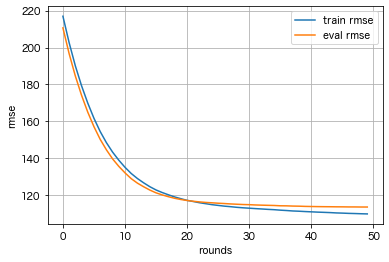

In [13]:
# 探索したパラメータで学習
#xgb_params = {'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent':1, 'randam_state':71,'n_estimators':40,'max_depth': 4,'learning_rate': 0.3,'min_child_weight':3}
xgb_params = {'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent':1, 'randam_state':71,'n_estimators':70,'max_depth': 6,'learning_rate': 0.1,'min_child_weight':3}
num_round = 50

evals = [(dtrain,'train'),(dtest,'eval')]
evals_result = {}
model = xgb.train(xgb_params,dtrain,num_round,evals=evals,evals_result=evals_result)

# 学習モデルの評価
test_pred = model.predict(dtest)
score = mean_squared_error(y_test, test_pred)
print('RMSE:', math.sqrt(score))

train_metric = evals_result['train']['rmse']
plt.plot(train_metric, label='train rmse')
eval_metric = evals_result['eval']['rmse']
plt.plot(eval_metric, label='eval rmse')
plt.grid()
plt.legend()
plt.xlabel('rounds')
plt.ylabel('rmse')
plt.show()

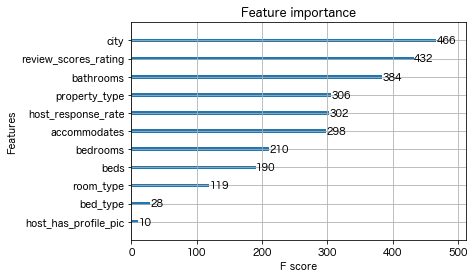

In [14]:
xgb.plot_importance(model)

In [15]:
pickle.dump(model, open("xgb_model_20200830_2.pickle", "wb"))

In [16]:
with open("test_processed_20200830_2.csv",'r',newline='',encoding="utf_8_sig") as inputfile: #改行コードがあることを明示,BOM付きファイル削除
    #DataFrameを作成。pandasuはread_csv()がカンマ区切り、read_table()がタブ区切りを読み込む
    test_data = pd.read_csv(inputfile)
    #header : ヘッダーがないのでNoneを指定。あれば0を指定（指定しないと１行目は勝手にヘッダー扱いになる）、
    #name : 適当に名前を付与
    #index_col : 行番号をindexに指定
    #usecols ：CSVの読み込み対象とする列を指定するprint("dfタイプ：", type(df))
print("\nサンプル表示\n")
test_data[0:1]


サンプル表示



,city,property_type,room_type,accommodates,bathrooms,bed_type,bedrooms,beds,review_scores_rating,host_response_rate,host_has_profile_pic
0,0,15,0,6,2.0,4,2.0,2.0,-0.577406,0.67438,1


In [17]:
x = test_data.copy()
y =[]
dpred = xgb.DMatrix(x)

In [18]:
y_pred = model.predict(dpred)

In [19]:
len(y_pred)

18528

In [20]:
y_pred

array([247.85432, 128.77478,  96.53545, ..., 234.24458, 152.95784,
        51.49492], dtype=float32)

In [21]:
df_score = pd.DataFrame(y_pred)

In [22]:
df_score[0:2]

,0
0,247.854324
1,128.774780


In [23]:
#ID+スコアの形に整形する
with open("test.csv",'r',newline='',encoding="utf_8_sig") as inputfile:
    df_test_id = pd.read_csv(inputfile, usecols =['id'])
print("\nサンプル表示\n")
df_test_id[0:2]


サンプル表示



,id
0,0
1,1


In [24]:
df_output = pd.concat([df_test_id,df_score], axis=1)

In [25]:
df_output

,id,0
0,0,247.854324
1,1,128.774780
2,2,96.535454
3,3,216.727188
4,4,147.104843
...,...,...
18523,18523,207.505661
18524,18524,112.140251
18525,18525,234.244583
18526,18526,152.957840


In [26]:
df_output.to_csv("submit_20200830.csv", header=False, index=False)